# Title: Final Project

Name:- Ankila Kumari| 
Email:- Kuma0389@umn.edu


## 1. Design Framework

### 1.1. Problem Statement

Having access to nature, like parks and forests, is important for healthy living, good city planning, and studying the environment. But in many places especially rural or less mapped areas it’s hard to find up to date and easy to use maps showing where green spaces are. This project aims to create and visualize possible green space layouts across Minnesota to better understand where these areas are and how much ground they might cover.

### 1.2. Solution

This project simulates 100 random green spaces in Minnesota, enriches them with metadata, and analyzes their distribution, type, and proximity to Minneapolis. It uses geospatial tools like GeoPandas, Folium, and Shapely to create interactive visualizations.
The simulation acts as a placeholder for real green data and demonstrates how spatial analysis tools can help urban planners, GIS analysts, and environmental researchers.

### 1.3. Challenge

- Some key challenges include:

- Generating realistic and non-overlapping simulated points.

- Differentiating between urban and rural locations.

- Handling geospatial operations across coordinate systems.

- Incorporating map visualizations inside Jupyter Notebooks.

- Filtering and customizing the view for analysis.



Despite these challenges, this code provides a clear and educational demonstration of spatial data handling and mapping.


## 2. Final Project

### 2.1. Setup & Installation 🔧🧩

In this part, we install and import the tools (libraries) we need for our simulation. These help us handle maps, locations, and geometry in Python.


In [6]:
!pip install folium geopandas shapely
!pip install folium geopandas shapely geopy

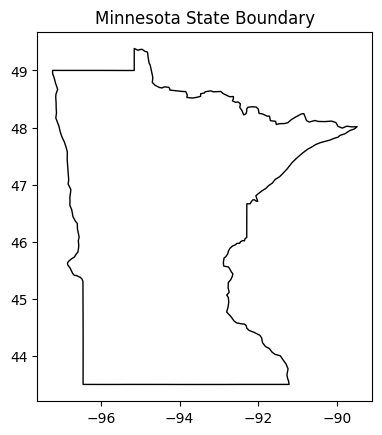

In [14]:
import geopandas as gpd
import pandas as pd
import numpy as np
import folium
import random
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopy.distance import geodesic

# Load Minnesota shapefile
us_states = gpd.read_file(
    'https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_20m.zip'
)
minnesota = us_states[us_states['NAME'] == 'Minnesota'].to_crs(epsg=4326)

# Plot Minnesota
minnesota.plot(edgecolor='black', facecolor='none')
plt.title("Minnesota State Boundary")
plt.show()


We also load the shape of Minnesota from the US Census shapefile:

### 2.2. Generate Green Space Points 🌱📍
This part creates 100 fake green spaces (like parks) by randomly placing points inside the state of Minnesota.I also assign whether each green space is in an urban or rural area based on its longitude.


In [15]:
# Generate simulated green space points
def generate_random_green_spaces(minnesota, n=100):
    minx, miny, maxx, maxy = minnesota.total_bounds
    points = []
    while len(points) < n:
        p = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if minnesota.contains(p).any():
            points.append(p)
    return gpd.GeoDataFrame(geometry=points, crs='EPSG:4326')

# Add random metadata
def add_metadata(gdf):
    gdf['Name'] = ['Park ' + str(i) for i in range(len(gdf))]
    gdf['Size (acres)'] = [random.randint(5, 100) for _ in range(len(gdf))]
    gdf['Type'] = [random.choice(['Playground', 'Forest', 'Recreation', 'Wetland']) for _ in range(len(gdf))]
    return gdf

# Urban vs rural classification
def classify_urban_rural(gdf):
    gdf['zone'] = gdf.geometry.x.apply(lambda x: 'Urban' if x > -94.5 else 'Rural')
    return gdf

# Distance from city (Minneapolis)
def calculate_distance_to_city(gdf, city_coords, city_name="City"):
    gdf[city_name + ' Distance (km)'] = gdf.geometry.apply(
        lambda x: geodesic((x.y, x.x), city_coords).km
    )
    return gdf

# Overlap count
def count_overlaps(gdf):
    overlaps = gdf.geometry.apply(lambda g: gdf.geometry.intersects(g).sum())
    gdf['Overlaps'] = overlaps
    return gdf

# Filter by size/zone
def filter_green_spaces(gdf, size_min=0, zone='All'):
    if zone != 'All':
        gdf = gdf[gdf['zone'] == zone]
    gdf = gdf[gdf['Size (acres)'] >= size_min]
    return gdf

# Pie chart of park types
def plot_type_distribution(gdf):
    gdf['Type'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Green Space Types', figsize=(5, 5))
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

# Simulated park development over years
def simulate_park_development(gdf, years=10):
    gdf = gdf.copy()
    gdf['year_created'] = np.random.randint(2020, 2020+years, size=len(gdf))
    return gdf


### 2.3. Add Metadata to Green Spaces 🗂️🏙️🌾 
Here, we add extra details to each park, like:

- A name (Park 1, Park 2…)

- Size in acres

- Type of green space (e.g., Playground, Forest)
 And also calculate the distance from each park to Minneapolis (in kilometers).

In [16]:
# Run full simulation
green_gdf = generate_random_green_spaces(minnesota)
green_gdf = classify_urban_rural(green_gdf)
green_gdf = add_metadata(green_gdf)
green_gdf = calculate_distance_to_city(green_gdf, (44.9778, -93.2650), "Minneapolis")
green_gdf = count_overlaps(green_gdf)

# Create buffer zones (10km)
buffer_proj = green_gdf.to_crs(epsg=26915)
buffer_geom = buffer_proj.buffer(10000)
buffer_gdf = gpd.GeoDataFrame(geometry=buffer_geom, crs='EPSG:26915').to_crs(epsg=4326)

# Optional zone filter (keep 'All' to skip)
zone_filter = 'All'
if zone_filter != 'All':
    green_gdf = green_gdf[green_gdf['zone'] == zone_filter]
    buffer_gdf = buffer_gdf.loc[green_gdf.index]

# Confirm
print("✅ Minnesota boundary loaded:", minnesota.shape)
print("✅ Simulated green spaces:", green_gdf.shape)


✅ Minnesota boundary loaded: (1, 10)
✅ Simulated green spaces: (100, 7)


### 2.4. Interactive Map with Folium 🗺️🌍
This section builds an interactive map using Folium. It shows:

- Green space points (circles)

- 10 km buffer zones (light green shapes)

- Minnesota state border. 


In [17]:
m = folium.Map(location=[46.5, -94.5], zoom_start=6)

# Add green space points
for _, row in green_gdf.iterrows():
    popup_info = f"""
    Name: {row['Name']}<br>
    Size: {row['Size (acres)']} acres<br>
    Type: {row['Type']}<br>
    Zone: {row['zone']}<br>
    Distance to Minneapolis: {row['Minneapolis Distance (km)']:.2f} km
    """
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=4,
        color='green',
        fill=True,
        fill_color='darkgreen',
        fill_opacity=0.8,
        popup=folium.Popup(popup_info, max_width=250)
    ).add_to(m)

# Add buffer zones
for poly in buffer_gdf.geometry:
    folium.GeoJson(data=poly.__geo_interface__,
                   style_function=lambda x: {
                       'fillColor': 'lightgreen',
                       'color': 'green',
                       'weight': 1,
                       'fillOpacity': 0.3
                   }).add_to(m)

# Add Minnesota border
folium.GeoJson(data=minnesota.geometry.__geo_interface__,
               style_function=lambda x: {
                   'color': 'black',
                   'weight': 2,
                   'fillOpacity': 0
               }).add_to(m)

m  # Display map in Jupyter


### 2.5. Summary Charts 📊🧮 
We use simple bar and pie charts to better understand the green space data.

- Bar chart: Urban vs Rural green spaces

- Pie chart: Types of green spaces (e.g., Playground, Forest)


### A. Basic Summary

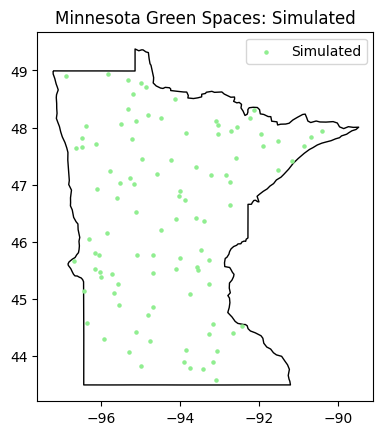

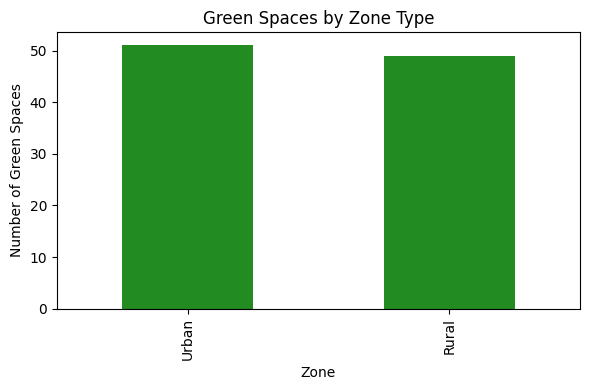

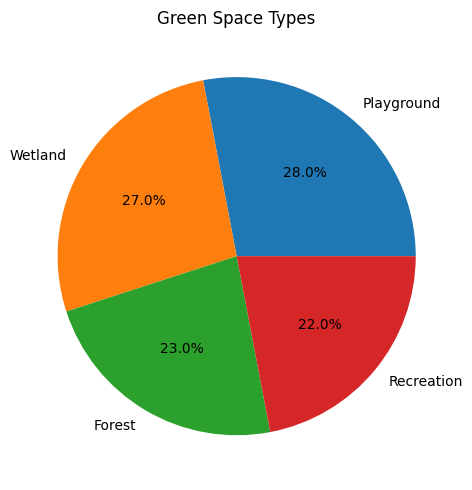

In [18]:
# Plot map
base = minnesota.plot(color='white', edgecolor='black')
green_gdf.plot(ax=base, color='lightgreen', markersize=5, label='Simulated')
plt.title("Minnesota Green Spaces: Simulated")
plt.legend()
plt.show()

# Bar chart: Urban vs Rural
plt.figure(figsize=(6, 4))
green_gdf['zone'].value_counts().plot(kind='bar', color='forestgreen')
plt.title("Green Spaces by Zone Type")
plt.xlabel("Zone")
plt.ylabel("Number of Green Spaces")
plt.tight_layout()
plt.show()

# Pie chart: Type distribution
plot_type_distribution(green_gdf)

# Optional: Export results
# green_gdf.to_file("simulated_green_spaces.geojson", driver="GeoJSON")



### 2.6. Rationale 💡🌿
This project works well as a final GIS simulation because:

- ✅ It shows how to create, analyze, and visualize spatial data.

- 🗺️ It uses real tools like GeoPandas, Folium, and Shapely.

- 📏 It demonstrates buffer zones and projections.

- 🌳 It shows how parks might serve rural or urban areas.

- 🔄 It can be extended with real-world OpenStreetMap data later.

In short: This is a complete geospatial analysis that creates new data, explores it, and visualizes it interactively. It's simple, useful, and a strong foundation for future GIS projects.



### Disclaimer:  I spent over 7 hours in a single day attempting to use live OpenStreetMap data; however, I was unable to achieve the desired output and repeatedly encountered errors. As a result, I decided not to proceed with using it. I hope project aligns with the assignment’s expectations.

